# Decision Tree

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

In [5]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, value = None):
        self.feature = feature    
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

In [6]:
# decision tree...
class decisionTree:
    def __init__(self, max_depth = 5, min_samples_split = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    def _gini_impurity(self, y):
        counts = Counter(y)
        impurity = 1    # the worst...no info gain
        for count in counts.values():
            prob = count / len(y)
            impurity -= prob ** 2
        return impurity
    
    def _information_gain(self, X, y, feature, threshold):
        parent_gini = self._gini_impurity(y)

        # Split data
        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold

        if sum(left_idx) == 0 or sum(right_idx) == 0:
            return 0

        n = len(y)
        n_left, n_right = sum(left_idx), sum(right_idx)
        gini_left = self._gini_impurity(y[left_idx])
        gini_right = self._gini_impurity(y[right_idx])

        weighted_gini = (n_left / n) * gini_left + (n_right / n) * gini_right
        return parent_gini - weighted_gini
    
    def _best_split(self, X, y):
        """Find the best feature and threshold to split on"""
        best_gain = -1
        best_feature, best_threshold = None, None
        n_features = X.shape[1]

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])[:100]  # 100 for efficiency
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold
    
    def _grow_tree(self, X, y, depth):
        n_samples = len(y)
        n_classes = len(np.unique(y))

        # Stopping criteria...
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            n_classes == 1):
            return Node(value=Counter(y).most_common(1)[0][0])

        # Finding best split
        feature, threshold = self._best_split(X, y)
        if feature is None:  # No valid split
            return Node(value=Counter(y).most_common(1)[0][0])

        # Splitting the data
        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold

        # Grow children
        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature, threshold, left, right)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [7]:
# loading the dataset
df = pd.read_csv('../dataset/satellite_signal_dataset.csv')
df.head()

,orbit_type,distance_m,frequency_hz,transmit_power_dbw,transmit_antenna_diameter_m,receive_antenna_diameter_m,rain_rate_mmhr,atmospheric_loss_db,pointing_error_deg,bandwidth_hz,...,transmit_antenna_gain_db,receive_antenna_gain_db,fspl_db,rain_attenuation_db,pointing_loss_db,transmit_power_dbm,received_power_dbm,noise_power_dbm,cn_ratio_db,signal_quality
0,GEO,3.565755e+07,1.626957e+09,24.599966,1.097824,2.302199,8.523263,1.951948,0.057916,2.376473e+07,...,23.220260,29.652463,187.712322,0.046653,0.001281,54.599966,-82.239514,-101.064908,18.825394,Good
1,MEO,1.153046e+07,2.732246e+10,13.690240,0.689636,2.678975,0.784847,1.817429,0.000000,2.574373e+07,...,43.684873,55.471854,202.409099,2.781469,0.000000,43.690240,-64.161030,-100.093471,35.932441,Good
2,LEO,8.547917e+05,6.435908e+09,16.932794,0.752718,1.550586,14.636986,1.377592,0.080622,4.398066e+07,...,31.886933,38.164197,167.251175,0.163628,0.017614,46.932794,-51.826086,-101.616579,49.790493,Good
3,LEO,6.793379e+05,2.754270e+10,23.265613,0.861342,1.080783,9.264690,1.733032,1.207310,2.521968e+06,...,45.685729,47.656980,177.883618,1.511315,35.145513,53.265613,-69.665155,-110.930365,41.265211,Good
4,GEO,3.586736e+07,1.499221e+10,19.641787,0.907307,1.160886,12.557483,1.412742,0.000000,2.388476e+07,...,40.854477,42.995185,207.053070,45.040371,0.000000,49.641787,-120.014733,-103.200321,-16.814412,Poor


In [8]:
# Encode categorical 'orbit_type'
df = pd.get_dummies(df, columns=['orbit_type'], prefix='orbit')

In [9]:
# Convert boolean columns to integer
for col in ['orbit_GEO', 'orbit_LEO', 'orbit_MEO']:
    if col in df.columns:
        df[col] = df[col].astype(int)

In [10]:
# Defining features and target
features = [col for col in df.columns if col != 'signal_quality']
X = df[features].values
y = df['signal_quality'].map({'Good': 2, 'Moderate': 1, 'Poor': 0}).values

In [11]:
# Standardizing features...
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_std[X_std == 0] = 1  # Avoid division by zero
X = (X - X_mean) / X_std

In [12]:
# train-test split
n_samples = X.shape[0]
indices = np.random.permutation(n_samples)
train_size = int(0.8 * n_samples)   # 80% training data
train_idx, test_idx = indices[:train_size], indices[train_size:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [13]:
# applying decision tree...
model =decisionTree(max_depth=5, min_samples_split=2)
model.fit(X_train, y_train)

In [14]:
# prediction on test set
y_pred = model.predict(X_test)

In [15]:
# accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8658


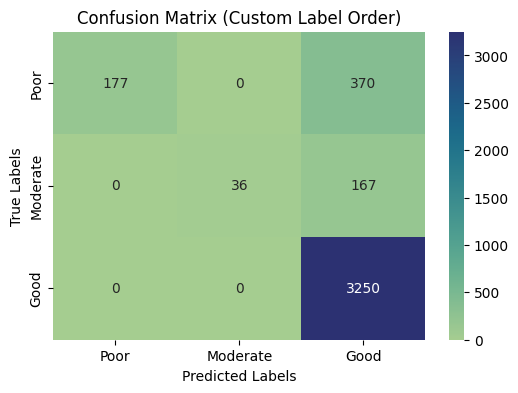

In [19]:
# confusion matrix
num_classes = 3
conf_matrix = np.zeros((num_classes, num_classes))
for true, pred in zip(y_test, y_pred):
    conf_matrix[int(true), int(pred)] += 1

# Custom label order: Good=2, Moderate=1, Poor=0
labels = ["Poor", "Moderate", "Good"] 

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="crest",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Custom Label Order)")
plt.show()

In [20]:
# Create a mapping from numerical labels back to original labels
label_mapping = {2: 'Good', 1: 'Moderate', 0: 'Poor'}
y_test_labels = [label_mapping[true] for true in y_test]
y_pred_labels = [label_mapping[pred] for pred in y_pred]

# Save predictions to CSV
results = pd.DataFrame({
    'True_Label': y_test_labels,
    'Predicted_Label': y_pred_labels
})
results.to_csv('../predictions/decision_tree_predictions.csv', index=False)
print("\nPredictions saved to 'decision_tree_predictions.csv'")


Predictions saved to 'decision_tree_predictions.csv'
